# Semantic Segmentation with convpaint and DINOv2
<a target="_blank" href="https://colab.research.google.com/github/quasar1357/dino_paint/blob/main/dino_paint.ipynb?hl=de"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks demonstrates how to run a semantic segmentation on an image using DINOv2 for feature extraction and a random forest algorithm for classification. It is based on the notebook provided by convpaint.


## Installs and Imports

In [ ]:
if False:
    !pip install -r https://raw.githubusercontent.com/quasar1357/dino_paint/main/requirements.txt

In [15]:
%load_ext autoreload
%autoreload 2

import napari
import numpy as np
from matplotlib import pyplot as plt
import skimage
from dino_paint_utils import (train_dino_forest,
                              predict_dino_forest,
                              selfpredict_dino_forest,
                              test_dino_forest,
                              pad_to_patch)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Choose the model

1) Choose the **DINOv2 model** to be used (assign None to not use DINOv2):

|key | model| features
|---|---|---|
|'s' | dinov2_vits14| 384|
|'b' | dinov2_vitb14| 768|
|'l' | dinov2_vitl14| 1024|
|'g' | dinov2_vitg14| 1536|
|+ '_r' | *base_model*_reg (not supported yet)| add registers|

2) Choose the **layers of DINOv2** to used features (give a list of indices 0-11); each layer has the number of features specific for the model as listed in the table above.

3) Choose the **extra pads** used before feature extraction with DINOv2, leading to a shift of the patches used in the feature extraction.

4) Choose the **layers of VGG16** to be attatched as additional features (give a list of indices; only use Conv2d layers; assign None to not use VGG16):

|index|layer|
|---|---|
|**0**|**Conv2d3, 64, kernel_size=3, stride=1, padding=1**|
|1|ReLUinplace=True|
|**2**|**Conv2d64, 64, kernel_size=3, stride=1, padding=1**|
|3|ReLUinplace=True|
|4|MaxPool2dkernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False|
|**5**|**Conv2d64, 128, kernel_size=3, stride=1, padding=1**|
|6|ReLUinplace=True|
|**7**|**Conv2d128, 128, kernel_size=3, stride=1, padding=1**|
|8|ReLUinplace=True|
|9|MaxPool2dkernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False|
|**10**|**Conv2d128, 256, kernel_size=3, stride=1, padding=1**|
|11|ReLUinplace=True|
|**12**|**Conv2d256, 256, kernel_size=3, stride=1, padding=1**|
|13|ReLUinplace=True|
|**14**|**Conv2d256, 256, kernel_size=3, stride=1, padding=1**|
|15|ReLUinplace=True|
|16|MaxPool2dkernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False|
|**17**|**Conv2d256, 512, kernel_size=3, stride=1, padding=1**|
|18|ReLUinplace=True|
|**19**|**Conv2d512, 512, kernel_size=3, stride=1, padding=1**|
|20|ReLUinplace=True|
|**21**|**Conv2d512, 512, kernel_size=3, stride=1, padding=1**|
|22|ReLUinplace=True|
|23|MaxPool2dkernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False|
|**24**|**Conv2d512, 512, kernel_size=3, stride=1, padding=1**|
|25|ReLUinplace=True|
|**26**|**Conv2d512, 512, kernel_size=3, stride=1, padding=1**|
|27|ReLUinplace=True|
|**28**|**Conv2d512, 512, kernel_size=3, stride=1, padding=1**|
|29|ReLUinplace=True|
|30|MaxPool2dkernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False|

5) Choose if the **image itself** (3 rgb channels) shall be added as features.

6) Choose the **scale factor combinations** to use, as a tuple (DINOv2_scales, VGG16_scales), whereas DINOv2_scales and VGG16_scales each is a list of scales to use for the respective model.



In [16]:
dinov2_model = 's'
dinov2_layers = [8,9,10,11]
extra_pads= [] #[7] #[2,4,6,8,10,12]
vgg16 = [2,7] # [0,2,5,7,10,12,14,17,19,21,24,26,28]
image_as_feature = True
scales = {"DINOv2": [1.0, 1.32, 1.73, 2.28, 3.0][:1],
          "VGG16": (1,2) }

upscale_order = 1
pad_mode = 'reflect'

show_napari = True

## Online loading & displaying

Define a function for loading images from url.

In [17]:
import PIL
import urllib

def load_url_to_array(url, from_github=False):
    return np.array(PIL.Image.open(urllib.request.urlopen(['', 'https://github.com/quasar1357/dino_paint/raw/main/images_and_labels/'][from_github] + url)))

Disable showing results in napari if working online (in colab), since it is not supported.

In [18]:
show_napari = False

## Train

Load an image and its annotation/labels to train the model on.

In [27]:
image_to_train = skimage.data.cells3d()
image_to_train = image_to_train[30, 1]
from napari_convpaint.convpaint_sample import create_annotation_cell3d
labels_to_train = create_annotation_cell3d()[0][0]
image_to_train = image_to_train[:, :126]
labels_to_train = labels_to_train[:, :126]

# crop = ((60,288), (0,178))
# crop = ((20,20+224), (0,224))
# image_to_train = image_to_train[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
# labels_to_train = labels_to_train[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

# LOAD ASTRONAUT IMAGE (RGB) AND ANNOTATION
# image_to_train = skimage.data.astronaut()#[0:504,0:504,:]
# labels_to_train = load_url_to_array('astro_labels.tif', True)#[0:504,0:504]

# LOAD HARDER CELL IMAGE AND ITS LABELS
# image_to_train = load_url_to_array('00_00016.tiff', True)
# labels_to_train = load_url_to_array('00_00016_labels.tiff', True)


Exctract the features using DINOv2 and/or VGG16 and use them to train a random forest classifier.

In [28]:
train = train_dino_forest(image_to_train, labels_to_train,
                          upscale_order=upscale_order, pad_mode=pad_mode, extra_pads=extra_pads, scales=scales,
                          dinov2_model=dinov2_model, dinov2_layers=dinov2_layers, vgg16_layers=vgg16, append_image_as_feature=image_as_feature,
                          show_napari=False)
random_forest, image_train, labels_train, feature_space_train = train

## Predict

Load an image to predict the labels for using the trained model above.

In [26]:
image_to_pred = skimage.data.cells3d()
image_to_pred = image_to_pred[40, 1][:,125:251]
ground_truth = load_url_to_array('cells_cross_ground_truth.tif', True)

# crop = ((20,248), (50,278))
# crop = ((20,20+224), (0,224))
# image_to_pred = image_to_pred[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

# LOAD AN IMAGE TO PREDICT BASED ON THE CLASSIFIER TRAINED ON THE ASTRONAUT IMAGE
# image_to_pred = skimage.data.camera()
# ground_truth = load_url_to_array('cam_ground_truth.tif', True)
# image_to_pred = skimage.data.cat()
# image_to_pred = skimage.data.horse().astype(np.int32)
# image_to_pred = skimage.data.binary_blobs().astype(np.int32)
# image_to_pred = skimage.data.coins()
# ground_truth = None


Exctract the features and use them together with the trained classifier to make a prediciton for the labels.

In [29]:
pred = predict_dino_forest(image_to_pred, random_forest, ground_truth=ground_truth,
                           upscale_order=upscale_order, pad_mode=pad_mode, extra_pads=extra_pads, scales=scales,
                           dinov2_model=dinov2_model, dinov2_layers=dinov2_layers, vgg16_layers=vgg16, append_image_as_feature=image_as_feature,
                           show_napari=show_napari)
predicted_labels, image_pred, feature_space_pred, acc = pred

If can't show in napari, show using matplotlib (excluding the feature space).

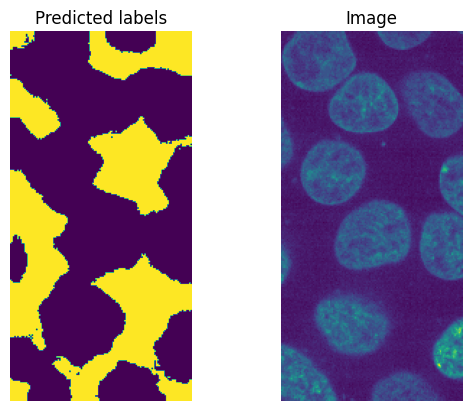

In [30]:
if not show_napari:
    ax = plt.subplots(1, 2)[1]
    ax[0].imshow(predicted_labels)
    ax[0].axis('off')
    ax[0].set_title('Predicted labels')

    ax[1].imshow(image_pred)
    ax[1].axis('off')
    ax[1].set_title('Image')

    plt.show()

## Selfpredict

We can also directly do a training and prediction on the same image (extracting the features only once).

In [21]:
self_pred_image = skimage.data.astronaut()#[0:504,0:504,:]
self_pred_labels = load_url_to_array('astro_labels.tif', True)#[0:504,0:504]
ground_truth = load_url_to_array('astro_ground_truth.tif', True)

# self_pred_image = image_to_train
# self_pred_labels = labels_to_train
# # ground_truth = None

self_pred = selfpredict_dino_forest(self_pred_image, self_pred_labels, ground_truth,
                                    upscale_order=upscale_order, pad_mode=pad_mode, extra_pads=extra_pads, scales=scales,
                                    dinov2_model=dinov2_model, dinov2_layers=dinov2_layers, vgg16_layers=vgg16, append_image_as_feature=image_as_feature,
                                    show_napari=show_napari)
predicted_labels, image_scaled, labels_scaled, feature_space, acc = self_pred

If can't show in napari, show using matplotlib (excluding the feature space).

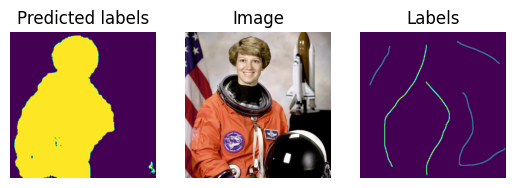

In [24]:
if not show_napari:
    ax = plt.subplots(1, 3)[1]
    ax[0].imshow(predicted_labels)
    ax[0].axis('off')
    ax[0].set_title('Predicted labels')

    ax[1].imshow(image_scaled)
    ax[1].axis('off')
    ax[1].set_title('Image')

    ax[2].imshow(labels_scaled)
    ax[2].axis('off')
    ax[2].set_title('Labels')

    plt.show()

## Tests against ground truth

In [ ]:
image_to_train = skimage.data.astronaut()#[200:300,250:400]
labels_to_train = load_url_to_array('astro_labels.tif', True)#[200:300,250:400]
image_to_pred = None #skimage.data.camera()
ground_truth = load_url_to_array('astro_ground_truth.tif', True)#[200:300,250:400]

# viewer = napari.Viewer()
# viewer.add_image(image_to_train)
# viewer.add_labels(labels_to_train)
# viewer_2 = napari.Viewer()
# viewer_2.add_image(image_to_pred)
# viewer_2.add_labels(ground_truth)

all_vggs = [0,2,5,7,10,12,14,17,19,21,24,26,28]
single_vggs = [[i] for i in all_vggs]
consecutive_vggs = [all_vggs[:s] for s in range(1,len(all_vggs))]
dual_vggs = [[all_vggs[i], all_vggs[j]] for i in range(len(all_vggs)) for j in range(i+1, len(all_vggs))]

dino_models = [None, 's']#, 'b']
dino_layer_combos = [(),
                     [8, 9, 10, 11]]
vgg_layer_combos = [None,
                    [2, 7],
                    [24,26,28]] #, all_vggs]#[0], [10], [17], [24], [0, 10, 17, 24]]#
scale_combos = [{"DINOv2": (), "VGG16": ()},
                {"DINOv2": (), "VGG16": (1,2)}] #[[1,2]] #, [1,2]]

In [ ]:
test = test_dino_forest(image_to_train, labels_to_train, ground_truth, image_to_pred,
                        dinov2_models=dino_models, dinov2_layer_combos=dino_layer_combos, vgg16_layer_combos=vgg_layer_combos, scale_combos=scale_combos,
                        print_avg=True, print_max=True)
accs, avg_accs, max_acc, ex_times = test

if show_napari:
    napari.imshow(accs)
    napari.imshow(ex_times)